# PyTorch code for a Multilayer Perceptron

In this section we will go through the code for a multilayer perceptron in PyTorch.

First of all we set up the required imports and set up the device used for training.

In [17]:
from __future__ import division, print_function, absolute_import
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

device = torch.device('cuda')
      
print('PyTorch version:', torch.__version__, ' Device:', device)

PyTorch version: 1.5.0+cu101  Device: cuda


Here are the relevant network parameters and graph input for context.

In [0]:
# Hyper-Parameters
learning_rate = 0.001 # Initial learning rate
training_epochs = 15 # Number of epochs to train
batch_size = 100 # Number of images per batch
display_step = 1 # How often to output model metrics during training

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

Here, we load the MNIST dataset from the torchvision library.

In [0]:
# The dataset
train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

test_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                batch_size=1, 
                                                shuffle=False)

### Model Creation
Here, we create a ‘multi-layer’ model as there is more than one hidden layer, as below we define `fc_1` and `fc_2`.

The MLP definition below does two things:

1. It defines the model in Multilayer_Perceptron().
2. It initialises and assigns values to each layer of the network.

In [0]:
class Multilayer_Perceptron(nn.Module):
    def __init__(self):
        super(Multilayer_Perceptron, self).__init__()

        # Hidden fully connected layers with 256 neurons
        self.fc1 = nn.Linear(n_input, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.out = nn.Linear(n_hidden_2, n_classes)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.out(x), dim=1)

### Define loss and optimizer

In the following snippet we define our model, loss operation, optimiser.

In [0]:
model = Multilayer_Perceptron().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

### Train and evaluate the model

In [22]:
# Set model to training mode
model.train()

# training loop
for epoch in range(training_epochs):
# Loop over each batch from the training set
    for batch_idx, (img, lbl) in enumerate(train_loader):
        # Copy image data to GPU if available
        img = img.to(device)
        lbl = lbl.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass image data through the network
        output = model(img)

        # Calculate loss
        loss = criterion(output, lbl)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
    
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1), "Loss = {:.9f}".format(loss.item()))

print("Optimization Finished!")

# list of labels and outputs to draw the confusion matrix
preds, gts = [], []

# set model to evaluation mode
model.eval()

correct = 0

for test_img, test_lbl in test_loader:

    test_img = test_img.to(device)
    test_lbl = test_lbl.to(device)

    output = model(test_img)

    _, pred = torch.max(output, dim=1)

    correct += pred.eq(test_lbl).cpu().sum()

    gts.append(test_lbl.item())
    preds.append(pred.item())

accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)

print("\nAccuracy:", accuracy.item())


Epoch: 0001 Loss = 0.124363020
Epoch: 0002 Loss = 0.031297177
Epoch: 0003 Loss = 0.026889855
Epoch: 0004 Loss = 0.017897749
Epoch: 0005 Loss = 0.064680055
Epoch: 0006 Loss = 0.004275438
Epoch: 0007 Loss = 0.005556562
Epoch: 0008 Loss = 0.002140177
Epoch: 0009 Loss = 0.007811825
Epoch: 0010 Loss = 0.012832348
Epoch: 0011 Loss = 0.003414106
Epoch: 0012 Loss = 0.034302332
Epoch: 0013 Loss = 0.001926801
Epoch: 0014 Loss = 0.017387452
Epoch: 0015 Loss = 0.025319984
Optimization Finished!

Accuracy: 97.79000091552734


We can draw the confusion matrix to get better insight into the performance of the model.

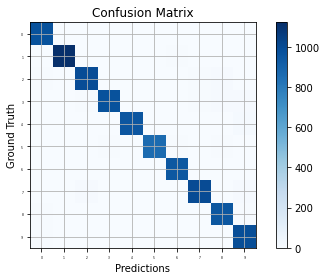

In [27]:
# Function to plot the confusion matrix:
def plot_confusion_matrix(gt, pred, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    cm = metrics.confusion_matrix(gt, pred)
    np.set_printoptions(precision=2)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, fontsize=3)
    plt.yticks(tick_marks, fontsize=3)

    plt.grid(True)

    plt.ylabel('Ground Truth')
    plt.xlabel('Predictions')
    plt.tight_layout()
    plt.savefig(f"cm.pdf", bbox_inches='tight')
    plt.show()
    plt.close()

# plot the confusion matrix
plot_confusion_matrix(gts, preds, test_dataset.classes)